In [101]:
from src import pipeline
from src import composite_analysis
from project_config import get_config

import os
import glob
from importlib import reload

import rasterio
from rasterio.plot import reshape_as_image, plotting_extent, show
from rasterio.warp import calculate_default_transform, reproject, Resampling

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box

import matplotlib.pyplot as plt
import contextily as ctx

root = '.'

cfg = get_config()

data_folder = pipeline.make_new_dir(root, 'data')
raw_folder = pipeline.make_new_dir(root, 'data/raw')
clipped_folder = pipeline.make_new_dir(root, 'data/clipped')
stacked_folder = pipeline.make_new_dir(root, 'data/stacked')
derived_folder = pipeline.make_new_dir(root, 'data/derived')
rois_folder = pipeline.make_new_dir(root, 'output/rois')
rois_initial_analysis_dir = pipeline.make_new_dir(rois_folder, 'initial_analysis')
tests_folder = pipeline.make_new_dir(root, 'tests')
envi_folder = pipeline.make_new_dir(data_folder, 'envi')

In [92]:
# Default figure size
plt.rcParams['figure.figsize'] = (10, 8)  # width, height in inches

# Default font sizes
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Optional: line widths and marker sizes
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6

## Obtain the study area bounding box
To ensure perfect consistency with ENVI, ENVI was used to clip a raw image and the bounding box and CRS was obtained programmatically from the result

In [ ]:
envi_clipped = envi_folder + r'/new_clipped_RGB.img'

replace_existing = False

bands_to_keep = {
    'LE07': ['B1','B2','B3','B4','B5','B6','B7'],
    'LC08': ['B1','B2','B3','B4','B5','B6','B7','B10', 'QA_PIXEL'],
    'LC09': ['B1','B2','B3','B4','B5','B6','B7','B10', 'QA_PIXEL']
}

composites = ['RGB', 'NDVI', 'MNDWI', 'NDBI', 'EVI', 'SAVI', 'FERRIC_IRON', 'BAI', 'SI', 'NDGI']
# , 'NDMI', 'CMI' # <-- these are the same as NDBI, really

cloud_threshold = 0.25

with rasterio.open(envi_clipped) as src:
    study_area_bbox, study_area_crs = src.bounds, src.crs
print(study_area_crs)
print(study_area_bbox)

bbox_geom = box(*study_area_bbox)
gdf = gpd.GeoDataFrame({'geometry': [bbox_geom]}, crs=study_area_crs)

# Compute total area in km²
area_km2 = pipeline.calculate_area_projected(bbox_geom)

EPSG:32652
BoundingBox(left=368985.0, bottom=27645.0, right=420735.0, top=100005.0)


C:\Users\anson\AppData\Roaming\Python\Python313\site-packages\matplotlib_scalebar\scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


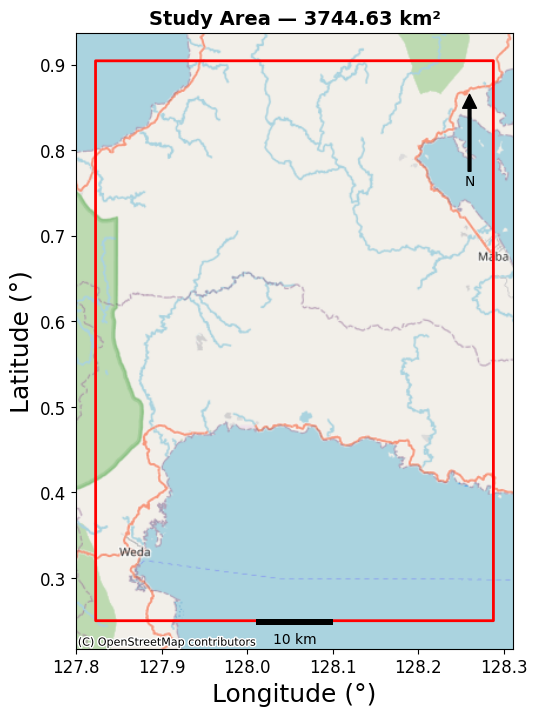

In [94]:
reload(pipeline)

# Reproject to WGS84 (lat/lon)
gdf_wgs84 = gdf.to_crs(epsg=4326)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_wgs84.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Add basemap
ctx.add_basemap(ax, crs=gdf_wgs84.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Labels and title
pipeline.PlotUtils.add_north_arrow(ax, location='upper right', pad=0.1)
pipeline.PlotUtils.add_scalebar(ax, location='lower center')
ax.set_title(f'Study Area — {area_km2:.2f} km²', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
plt.show()

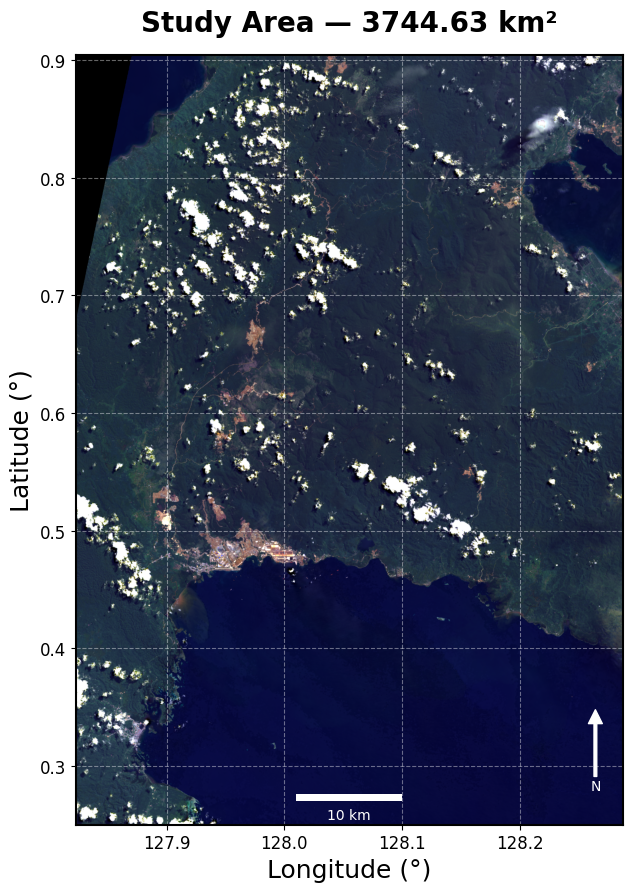

In [95]:
reload(pipeline)

raster_path = derived_folder + '/LC08_L2SP_109060_20230506_20230509_02_T1/RGB'

def stretch_rgb(rgb, lower=2, upper=98):
    """Apply percentile stretch for brightness and contrast."""
    rgb_stretched = np.zeros_like(rgb, dtype=float)
    for i in range(3):
        p_low, p_high = np.percentile(rgb[i], (lower, upper))
        rgb_stretched[i] = np.clip((rgb[i] - p_low) / (p_high - p_low), 0, 1)
    return rgb_stretched

# --- Open and reproject to lat/lon ---
with rasterio.open(raster_path) as src:
    dst_crs = 'EPSG:4326'
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    rgb_reproj = np.zeros((3, height, width), dtype=np.float32)
    for i in range(3):
        reproject(
            source=rasterio.band(src, i + 1),
            destination=rgb_reproj[i],
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )

# --- Stretch and plot ---
rgb_plot = np.transpose(stretch_rgb(rgb_reproj), (1, 2, 0))

fig, ax = plt.subplots(figsize=(10, 10))
extent = (transform[2], transform[2] + transform[0]*rgb_plot.shape[1], transform[5] + transform[4]*rgb_plot.shape[0], transform[5])

ax.imshow(rgb_plot, extent=extent)
ax.set_title(f'Study Area — {area_km2:.2f} km²', fontweight='bold', pad=17)

pipeline.PlotUtils.add_north_arrow(color='white')
pipeline.PlotUtils.add_scalebar(ax, colour='white')

# Border and labels
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.grid(True, color='white', linestyle='--', alpha=0.4)

plt.show()

### List the dates for which raw data exists

In [96]:
from datetime import datetime

# Extract date and sensor info
raw_data_dates = [pipeline.extract_scene_date(x) for x in os.listdir(raw_folder)]
sensors = [pipeline.extract_landsat_token(x) for x in os.listdir(raw_folder)]

# Convert to DataFrame
df = pd.DataFrame({
    'date': pd.to_datetime(raw_data_dates, format='%Y%m%d'),
    'sensor': sensors
})
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Pivot: months as rows, years as columns, sensors as values
pivot_df = df.pivot_table(index='month', columns='year', values='sensor', aggfunc=lambda x: ', '.join(sorted(set(x))))

# Sort months and fill blanks
pivot_df = pivot_df.sort_index().fillna('')

display(pivot_df)


year   2013  2016  2017  2018  2019  2020  2021  2022        2023        2024  \
month                                                                           
1            LC08                    LC08  LC08  LC08        LC08               
2            LC08              LC08                          LC09  LC08, LC09   
3                              LC08  LC08  LC08              LC08               
4                                    LC08  LC08              LC09        LC08   
5            LC08  LC08  LC08  LC08  LC08        LC08  LC08, LC09               
6            LC08        LC08  LC08        LC08  LC09                           
7                        LC08  LC08              LC08        LC09        LC08   
8                                          LC08  LC08                           
9                        LC08  LC08                                      LC08   
10     LC08        LC08  LC08              LC08  LC08        LC09        LC08   
11           LC08  LC08                    LC08  LC08        LC08               
12                 LC08        LC08  LC08  LC08              LC08        LC08   

year   2025  
month        
1            
2      LC08  
3      LC09  
4            
5      LC08  
6            
7      LC09  
8            
9            
10           
11           
12

## Clip raw satellite images to study area

In [97]:
reload(pipeline)

files_clipped = pipeline.clip_raw_scenes_to_study_area(raw_folder, clipped_folder, study_area_bbox, bands_to_keep, replace_existing)
print(f'Files clipped: {files_clipped}')

Files clipped: 0


## Take the clipped bands and stack them

In [98]:
reload(pipeline)

files_stacked = pipeline.stack_all_bands_in_dir(clipped_folder, stacked_folder, bands_to_keep, replace_existing)
print(f'Files stacked: {files_stacked}')

Files stacked: 0


## Generate composite images from stacks

In [102]:
reload(pipeline)

composites_created = pipeline.build_composites_from_stacks(stacked_folder, derived_folder, composites, cfg.band_map, replace_existing=replace_existing)
print(f'Composites generated: {composites_created}')

Composites generated: 0


## Timeseries analysis

### Cloud cover can be a problem in individual ROIs; check the cloud cover per ROI for each scene

In [103]:
reload(composite_analysis)
clouds_df = composite_analysis.compute_cloud_cover_all_scenes(clipped_folder, rois_initial_analysis_dir)
clouds_df.index = clouds_df.index.map(lambda x: pipeline.extract_scene_date(x))

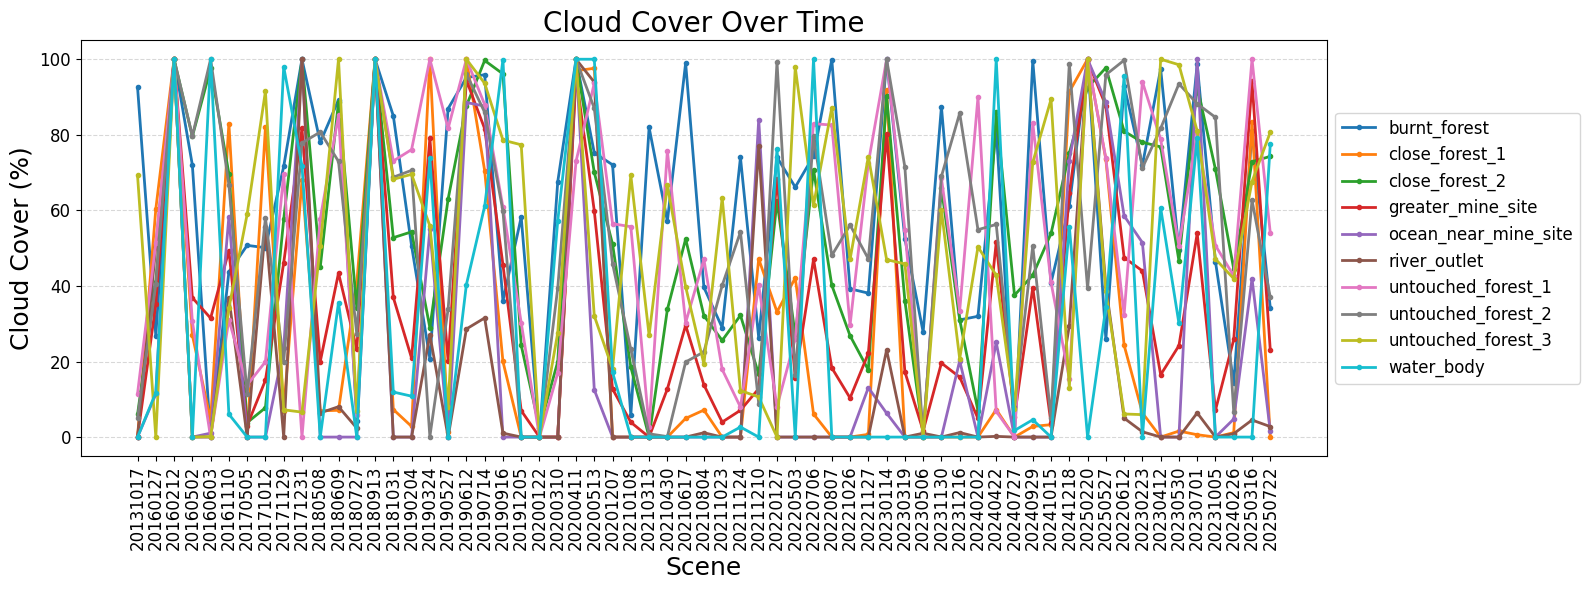

In [104]:
plt.figure(figsize=(16,6))

for roi in clouds_df.columns:
    plt.plot(clouds_df.index, clouds_df[roi], marker='.', label=roi)

plt.xlabel('Scene')
plt.ylabel('Cloud Cover (%)')
plt.title('Cloud Cover Over Time')
plt.xticks(rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.3)
plt.show()

### Index changes over time by ROI, calculated with a cloud mask

In [ ]:
reload(composite_analysis)

recalculate_stats = False

if recalculate_stats:
    all_stats = composite_analysis.compute_scene_roi_stats(derived_folder, rois_initial_analysis_dir, clipped_folder, composites)
    all_stats.to_csv(cfg.paths.initial_analysis_all_stats_csv_file_path, index=True)
else:
    all_stats = pd.from_csv(cfg.paths.initial_analysis_all_stats_csv_file_path)

c:\Users\anson\Documents\University\2\GEOM90005 Remote Sensing\Project\wedabaywatch\src\composite_analysis.py:600: RuntimeWarning: Mean of empty slice
  'mean': np.nanmean(roi_data),
C:\Users\anson\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\anson\Documents\University\2\GEOM90005 Remote Sensing\Project\wedabaywatch\src\composite_analysis.py:602: RuntimeWarning: All-NaN slice encountered
  'min': np.nanmin(roi_data),
c:\Users\anson\Documents\University\2\GEOM90005 Remote Sensing\Project\wedabaywatch\src\composite_analysis.py:603: RuntimeWarning: All-NaN slice encountered
  'max': np.nanmax(roi_data),
c:\Users\anson\Documents\University\2\GEOM90005 Remote Sensing\Project\wedabaywatch\src\composite_analysis.py:600: RuntimeWarning: Mean of empty slice
  'mean': np.nanmean(roi_data),
C:\Users\anson\AppData\Roaming\Python\Python313

### Use a threshold to filter on cloud cover

In [106]:
# Change index names to the date and sort by date
all_stats.index = all_stats.index.map(lambda x: pipeline.extract_scene_date(x))
all_stats = all_stats.sort_index()

all_stats_filtered_on_cloud = composite_analysis.filter_all_stats_on_threshold_value(all_stats, cloud_threshold, 'cloud_fraction')
all_stats_filtered_on_cloud

burnt_forest  \
20131017                                               None   
20160127                                               None   
20160212                                               None   
20160502                                               None   
20160603  {'cloud_fraction': 0.0, 'RGB': {'mean': 9223.9...   
...                                                     ...   
20241218                                               None   
20250220                                               None   
20250316                                               None   
20250527                                               None   
20250722                                               None   

                                             close_forest_1  \
20131017  {'cloud_fraction': 0.0, 'RGB': {'mean': 8263.8...   
20160127                                               None   
20160212                                               None   
20160502                                               None   
20160603  {'cloud_fraction': 0.04492129929847315, 'RGB':...   
...                                                     ...   
20241218                                               None   
20250220                                               None   
20250316                                               None   
20250527                                               None   
20250722  {'cloud_fraction': 0.0006484701998467253, 'RGB...   

                                             close_forest_2  \
20131017  {'cloud_fraction': 0.059789107511686056, 'RGB'...   
20160127                                               None   
20160212                                               None   
20160502                                               None   
20160603                                               None   
...                                                     ...   
20241218                                               None   
20250220                                               None   
20250316                                               None   
20250527                                               None   
20250722                                               None   

                                          greater_mine_site  \
20131017  {'cloud_fraction': 0.0004909310440909152, 'RGB...   
20160127                                               None   
20160212                                               None   
20160502                                               None   
20160603                                               None   
...                                                     ...   
20241218                                               None   
20250220                                               None   
20250316                                               None   
20250527                                               None   
20250722  {'cloud_fraction': 0.23006090198628046, 'RGB':...   

                                       ocean_near_mine_site  \
20131017  {'cloud_fraction': 0.0, 'RGB': {'mean': 7281.6...   
20160127  {'cloud_fraction': 0.11324376199616124, 'RGB':...   
20160212                                               None   
20160502  {'cloud_fraction': 0.0, 'RGB': {'mean': 7039.6...   
20160603  {'cloud_fraction': 0.010419522895530574, 'RGB'...   
...                                                     ...   
20241218                                               None   
20250220                                               None   
20250316                                               None   
20250527                                               None   
20250722  {'cloud_fraction': 0.015355086372360844, 'RGB'...   

                                               river_outlet  \
20131017  {'cloud_fraction': 0.0, 'RGB': {'mean': 7229.4...   
20160127                                               None   
20160212                                               None   
20160502  

### Get specific statistic for an index over time and plot it

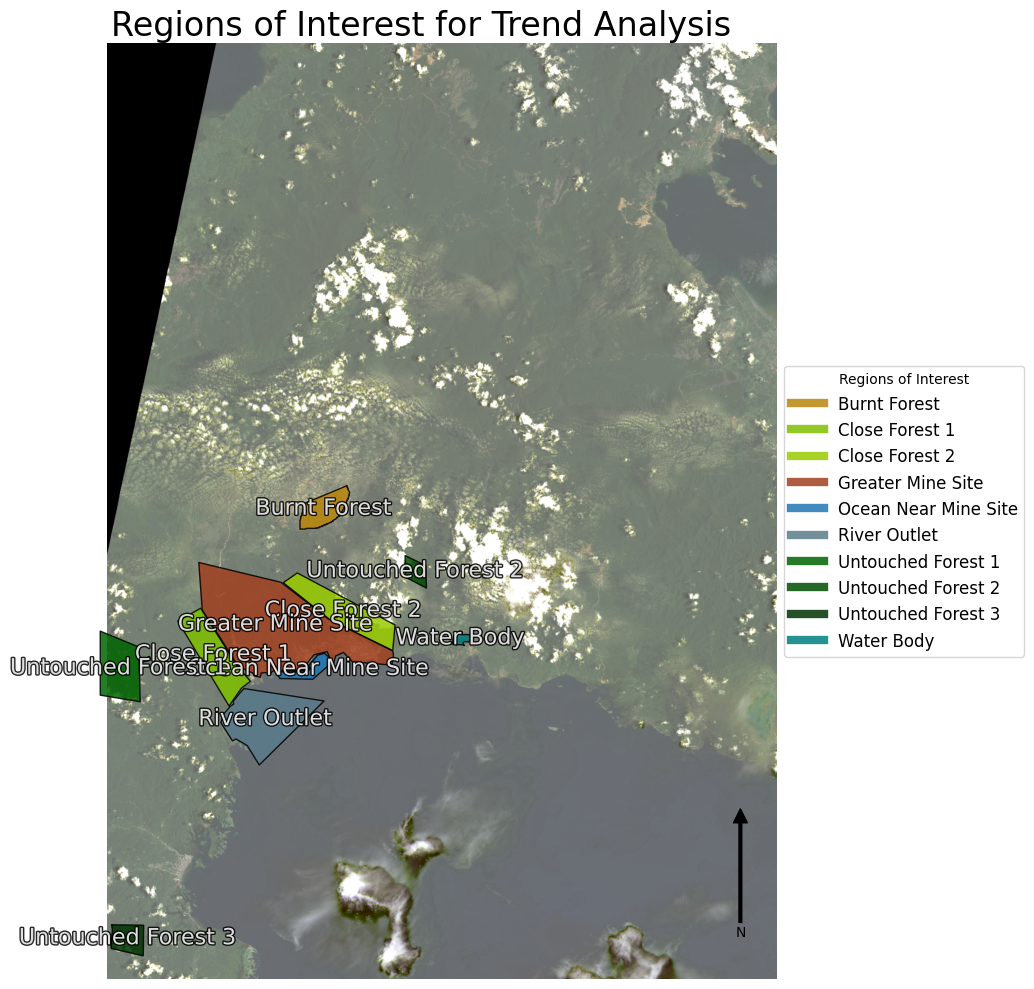

In [ ]:
reload(composite_analysis)

rois_folder = c.paths.rois_initial
all_rois = composite_analysis.get_roi_shapefiles(rois_folder)
roi_colours = cfg.rois.colors

composite_analysis.plot_rois_on_basemap(rois_initial_analysis_dir, derived_folder + '/LC08_L2SP_109060_20200310_20200822_02_T1/RGB', 
                                        roi_colours, title='Regions of Interest for Trend Analysis', highlight_rois=all_rois, alphas={'default': 0.15, 'highlight': 0.85})

### Obtain dictionary just of mean values

In [123]:
reload(composite_analysis)
means_dict = {}
for composite in [c for c in composites if c.lower() != 'rgb']:
    means_dict[composite] = composite_analysis.extract_stat_df(all_stats_filtered_on_cloud, composite=composite, stat='mean')

# display(means_dict['NDVI'])

### Conduct ROI-based analysis

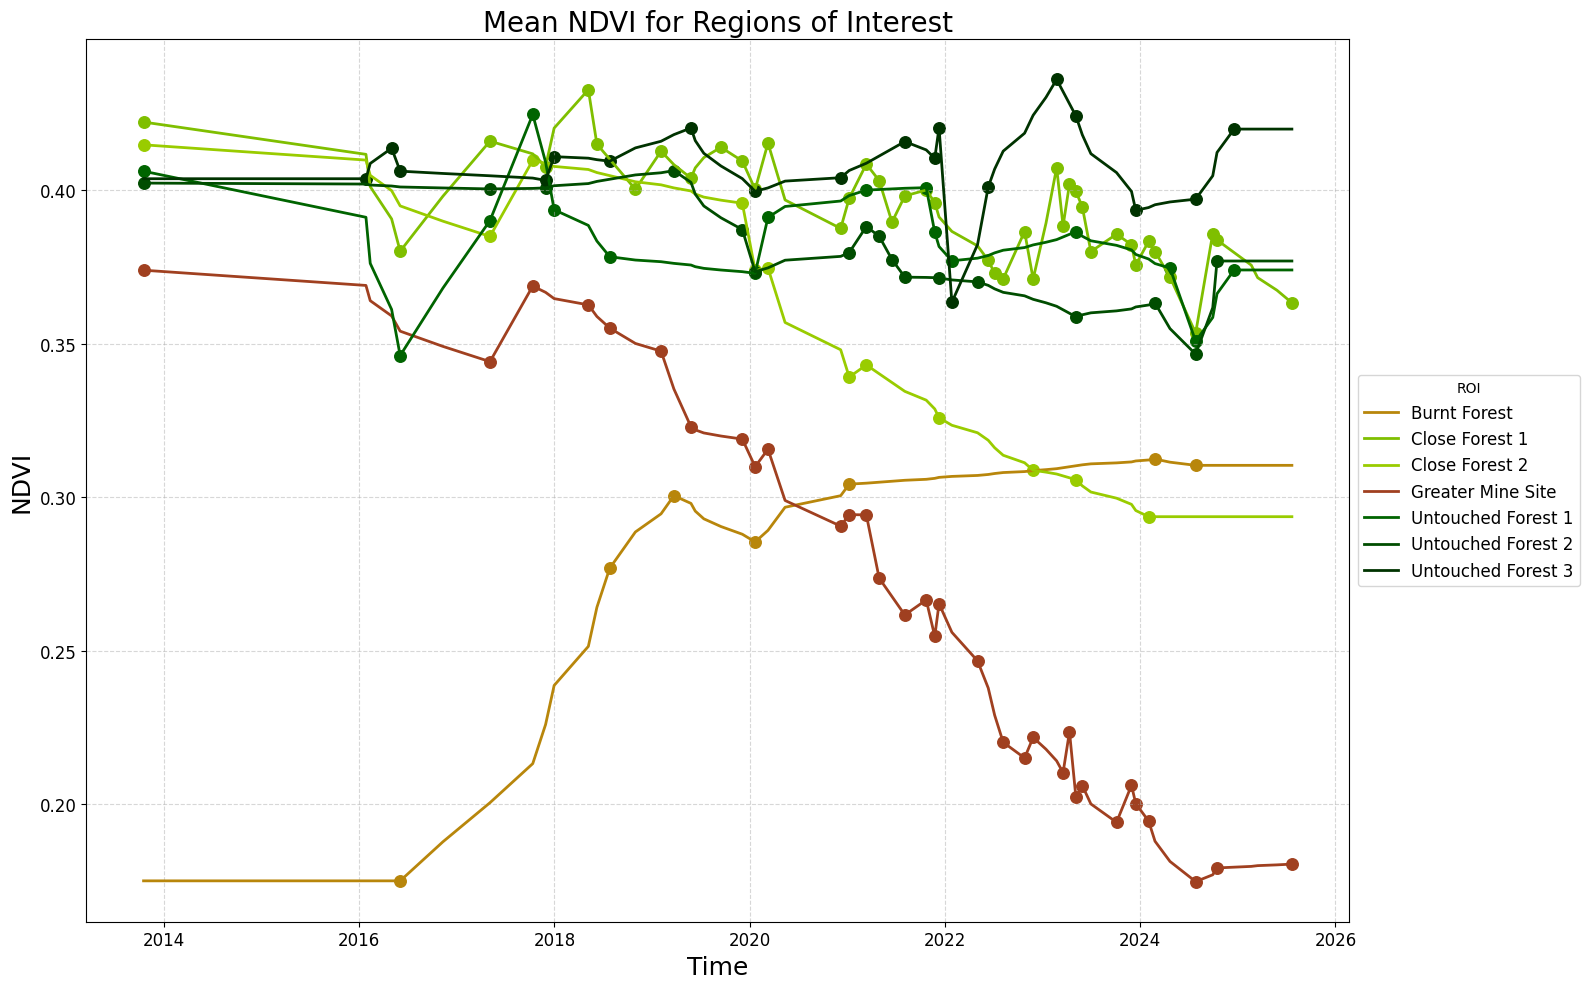

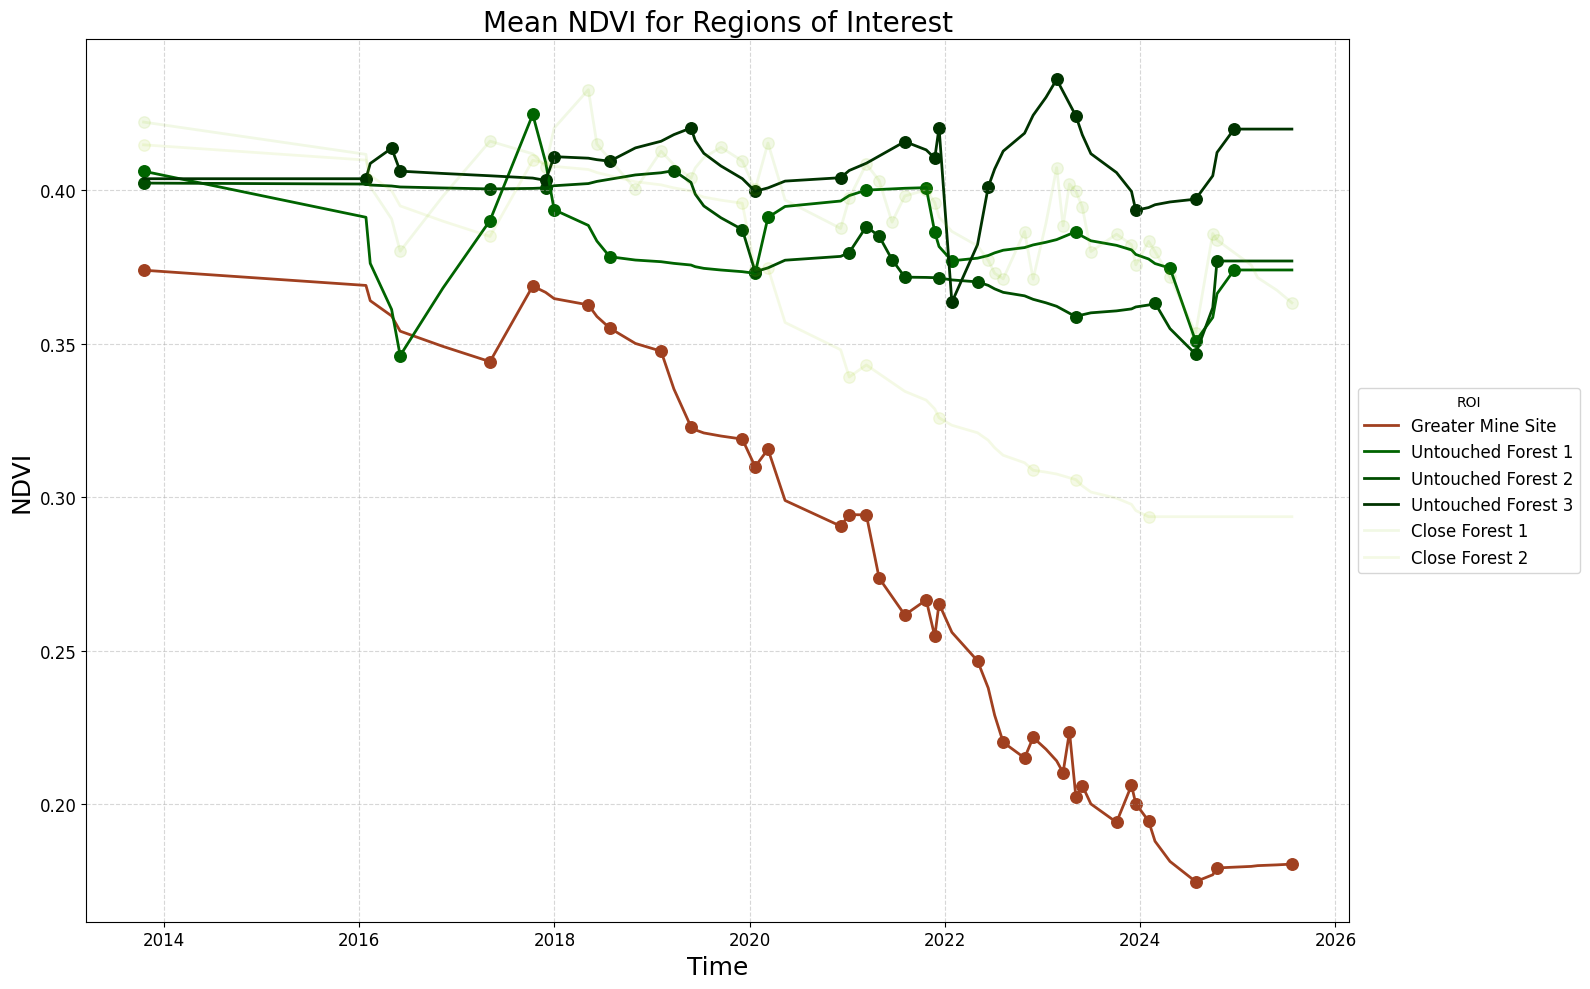

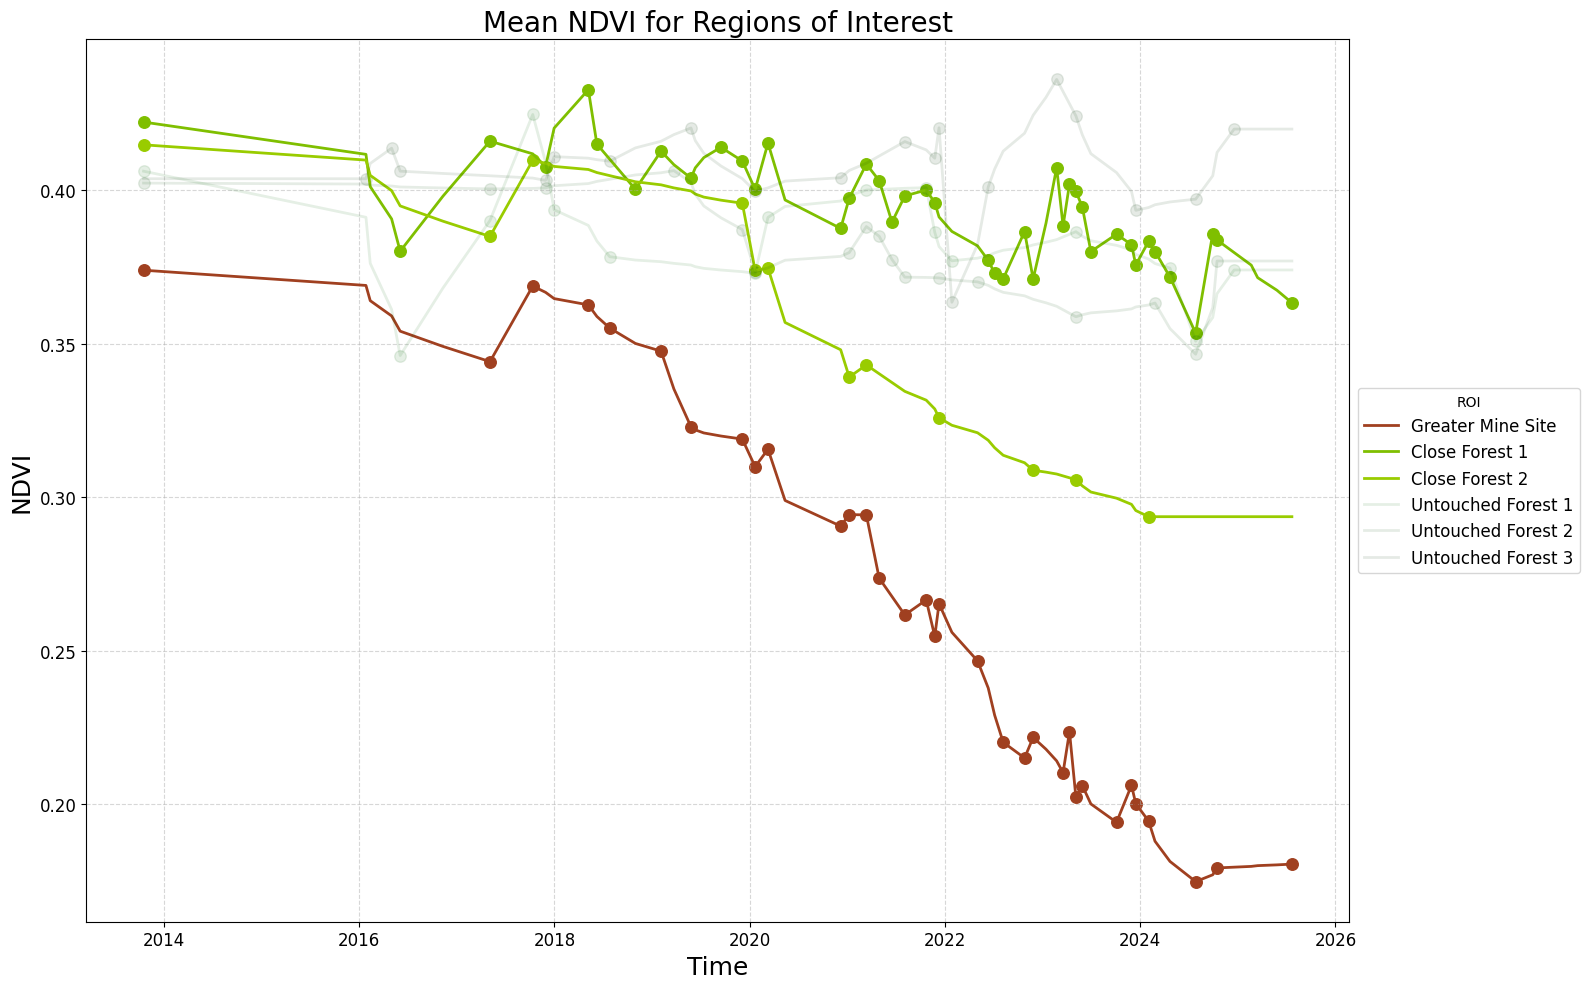

In [124]:
reload(composite_analysis)

all_rois = all_stats.columns.to_list()
water_rois = ['ocean_near_mine_site', 'river_outlet', 'water_body']
close_forest_rois = ['close_forest_1', 'close_forest_2']
untouched_forest_rois = ['untouched_forest_1', 'untouched_forest_2', 'untouched_forest_3']
forest_rois = close_forest_rois + untouched_forest_rois + ['burnt_forest']
mine_rois = ['greater_mine_site']
terrestrial_rois = [roi for roi in all_rois if roi not in water_rois]

composite_analysis.plot_roi_timeseries(means_dict['NDVI'], rois=terrestrial_rois, roi_colours=roi_colours, ylabel='NDVI', title='Mean NDVI for Regions of Interest')
composite_analysis.plot_roi_timeseries(means_dict['NDVI'], rois=mine_rois+untouched_forest_rois, roi_comparisons=close_forest_rois, roi_colours=roi_colours, ylabel='NDVI', title='Mean NDVI for Regions of Interest')
composite_analysis.plot_roi_timeseries(means_dict['NDVI'], rois=mine_rois+close_forest_rois, roi_comparisons=untouched_forest_rois, roi_colours=roi_colours, ylabel='NDVI', title='Mean NDVI for Regions of Interest')

### Compute long-term trends
Linear trends calculated for each composite/index per ROI

In [86]:
reload(composite_analysis)

trends_dict = {}
for composite in [c for c in composites if c.upper() != 'RGB']:
    trends_dict[composite] = {}
    for roi in all_rois:
        slope, intercept, r2, p = composite_analysis.calculate_linear_trend(means_dict[composite], composite, roi, plot=False)
        trends_dict[composite][roi] = {'slope':f'{slope:.4e}', 'R²':f'{r2:.3f}', 'p':f'{p:.4f}'}

# trends_dict['BAI']

### Filter only for statistically significant trends
Determine the number of statistically significant trends per ROI and per index

In [131]:
p_threshold = 0.01
r2_threshold = 0

records = []
for comp, roi_dict in trends_dict.items():
    for roi, stats in roi_dict.items():
        records.append({
            'composite': comp,
            'roi': roi,
            'slope': float(stats['slope']),
            'R2': float(stats['R²']),
            'p': float(stats['p'])
        })

df_trends = pd.DataFrame(records)

# Filter significant, strong-fit trends
df_filtered = df_trends[(df_trends['p'] < p_threshold) & (df_trends['R2'] > r2_threshold)].copy()
significance_mask = (df_trends['p'] < p_threshold) & (df_trends['R2'] > r2_threshold)

# Rank by slope magnitude
df_filtered['abs_slope'] = df_filtered['slope'].abs()

# Mark significance in the DataFrame
df_trends['significant'] = significance_mask

# Table 1: Significant trends per ROI
roi_table = (
    df_trends.groupby('roi')['significant']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'roi': 'Region of Interest', 'significant': 'Significant Trends'})
)

roi_table['Region of Interest'] = roi_table['Region of Interest'].apply(lambda x: x.replace('_', ' ').title())
# roi_table = roi_table.drop(columns='Region of Interest').rename(columns={'significant': 'Significant Trends'})


# Table 2: Significant trends per Composite
composite_table = (
    df_trends.groupby('composite')['significant']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'composite': 'Composite', 'significant': 'Significant Trends'})
)

# Optionally, style for presentation
display(roi_table.style.set_table_styles([
    {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('font-size', '11pt'), ('text-align', 'center')]}
]).hide(axis="index"))

display(composite_table.style.set_table_styles([
    {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('font-size', '11pt'), ('text-align', 'center')]}
]).hide(axis="index")
)

In [90]:
top_trends_per_roi = (
    df_filtered.sort_values(['roi', 'abs_slope'], ascending=[True, False])
               .groupby('roi')
               .head(69)
               .reset_index(drop=True)
)

display(top_trends_per_roi)

composite                 roi         slope     R2       p     abs_slope
0          SAVI        burnt_forest  6.368200e-10  0.681  0.0000  6.368200e-10
1          NDBI        burnt_forest -5.739600e-10  0.817  0.0000  5.739600e-10
2          NDVI        burnt_forest  4.245600e-10  0.681  0.0000  4.245600e-10
3            SI        burnt_forest  3.220600e-10  0.671  0.0000  3.220600e-10
4   FERRIC_IRON        burnt_forest -2.694300e-10  0.905  0.0000  2.694300e-10
5         MNDWI        burnt_forest  2.520400e-10  0.877  0.0000  2.520400e-10
6          NDGI        burnt_forest  1.380200e-10  0.909  0.0000  1.380200e-10
7          SAVI      close_forest_1 -2.211500e-10  0.468  0.0001  2.211500e-10
8          NDVI      close_forest_1 -1.474400e-10  0.468  0.0001  1.474400e-10
9          NDBI      close_forest_1  1.354100e-10  0.576  0.0000  1.354100e-10
10           SI      close_forest_1 -1.225600e-10  0.469  0.0001  1.225600e-10
11  FERRIC_IRON      close_forest_1  4.018500e-11  0.235  0.0090  4.018500e-11
12         SAVI      close_forest_2 -5.440600e-10  0.536  0.0002  5.440600e-10
13         NDVI      close_forest_2 -3.627100e-10  0.536  0.0002  3.627100e-10
14         NDBI      close_forest_2  3.056800e-10  0.589  0.0001  3.056800e-10
15           SI      close_forest_2 -3.016600e-10  0.543  0.0002  3.016600e-10
16          EVI   greater_mine_site -4.652500e-09  0.632  0.0000  4.652500e-09
17         SAVI   greater_mine_site -1.025900e-09  0.874  0.0000  1.025900e-09
18         NDVI   greater_mine_site -6.839400e-10  0.874  0.0000  6.839400e-10
19           SI   greater_mine_site -5.309900e-10  0.874  0.0000  5.309900e-10
20         NDBI   greater_mine_site  4.470500e-10  0.865  0.0000  4.470500e-10
21  FERRIC_IRON   greater_mine_site  2.506000e-10  0.821  0.0000  2.506000e-10
22        MNDWI   greater_mine_site  1.523600e-10  0.683  0.0000  1.523600e-10
23         NDGI   greater_mine_site -1.283800e-10  0.832  0.0000  1.283800e-10
24          BAI   greater_mine_site  1.433100e-18  0.318  0.0022  1.433100e-18
25  FERRIC_IRON        river_outlet -8.287200e-11  0.327  0.0010  8.287200e-11
26         NDGI        river_outlet  4.471800e-11  0.327  0.0010  4.471800e-11
27         SAVI  untouched_forest_2 -2.120700e-10  0.498  0.0016  2.120700e-10
28         NDBI  untouched_forest_2  1.489000e-10  0.657  0.0001  1.489000e-10
29         NDVI  untouched_forest_2 -1.413800e-10  0.498  0.0016  1.413800e-10
30           SI  untouched_forest_2 -1.216800e-10  0.529  0.0009  1.216800e-10

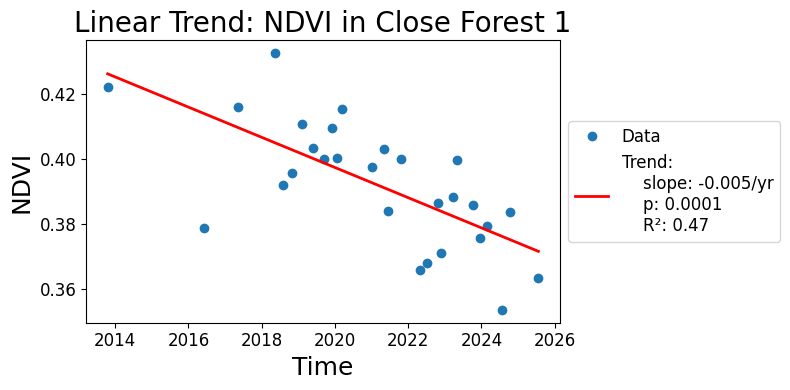

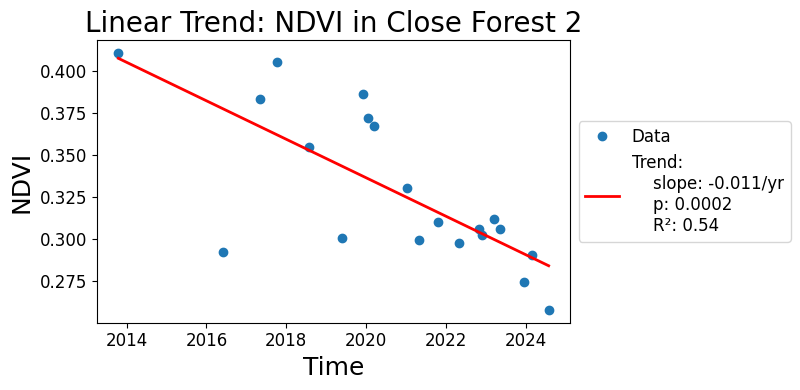

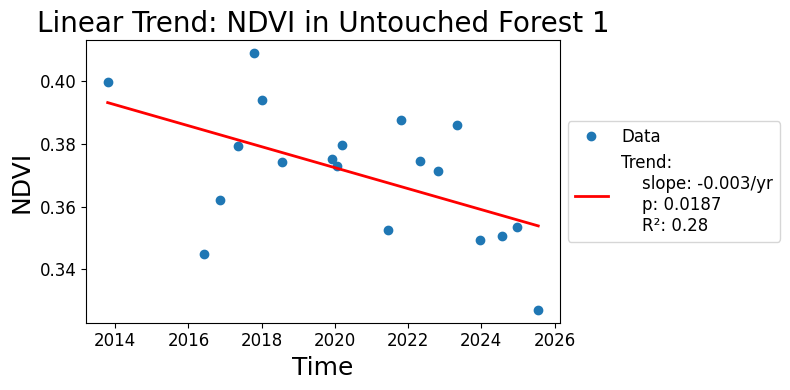

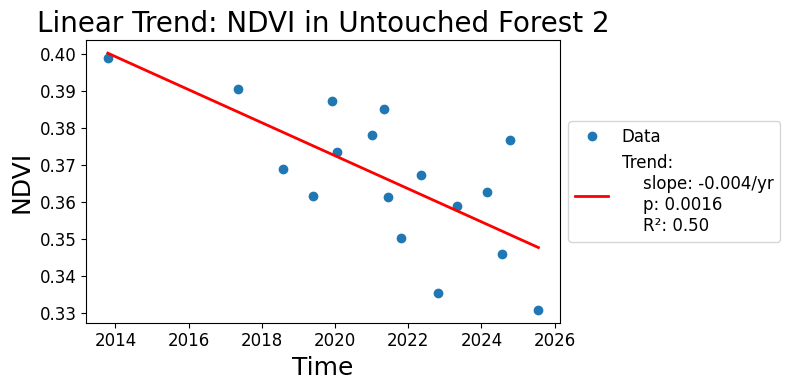

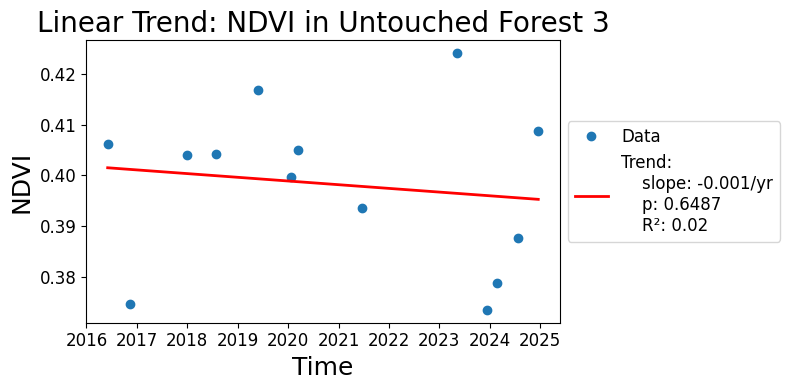

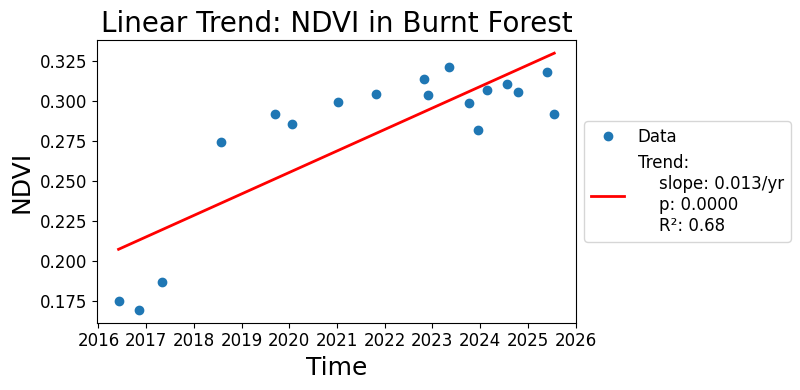

In [114]:
reload(composite_analysis)

for roi in forest_rois:
    composite_analysis.calculate_linear_trend(means_dict['NDVI'], 'NDVI', roi, plot=True)

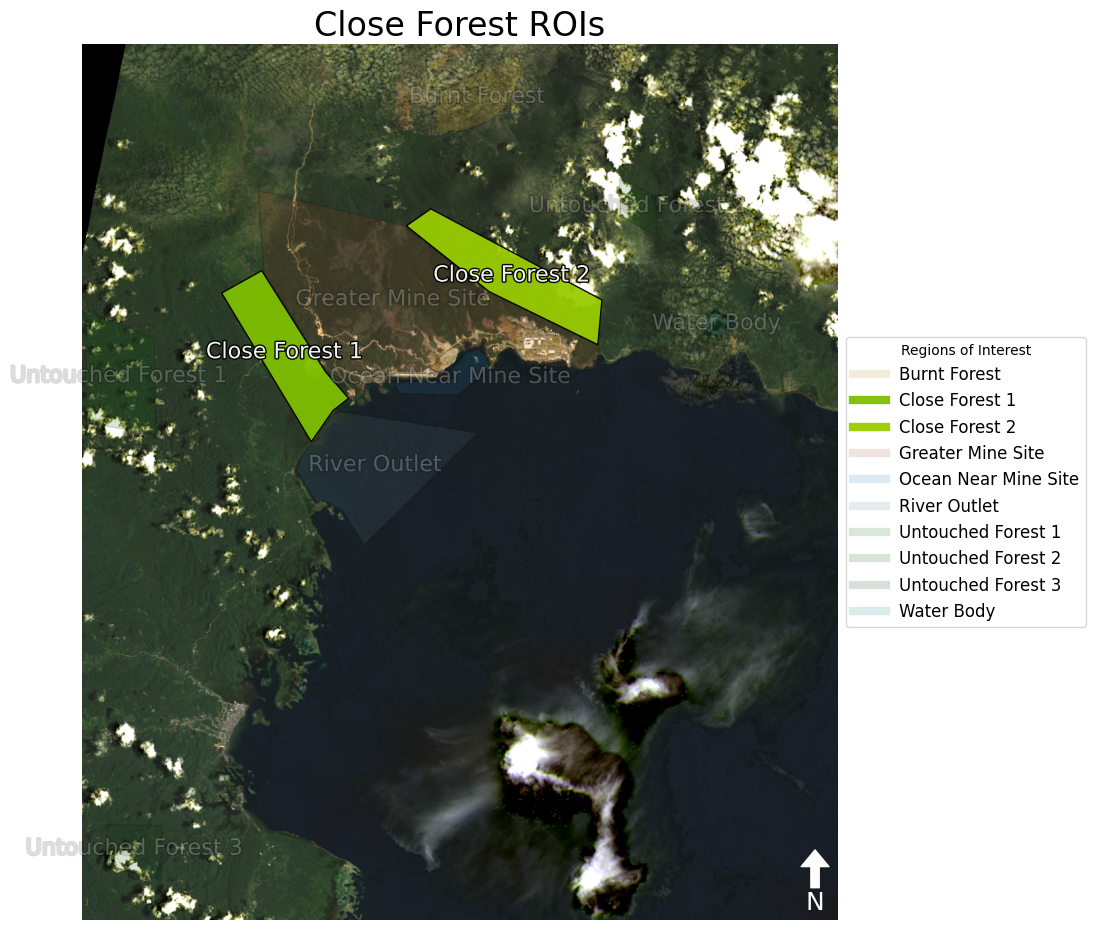

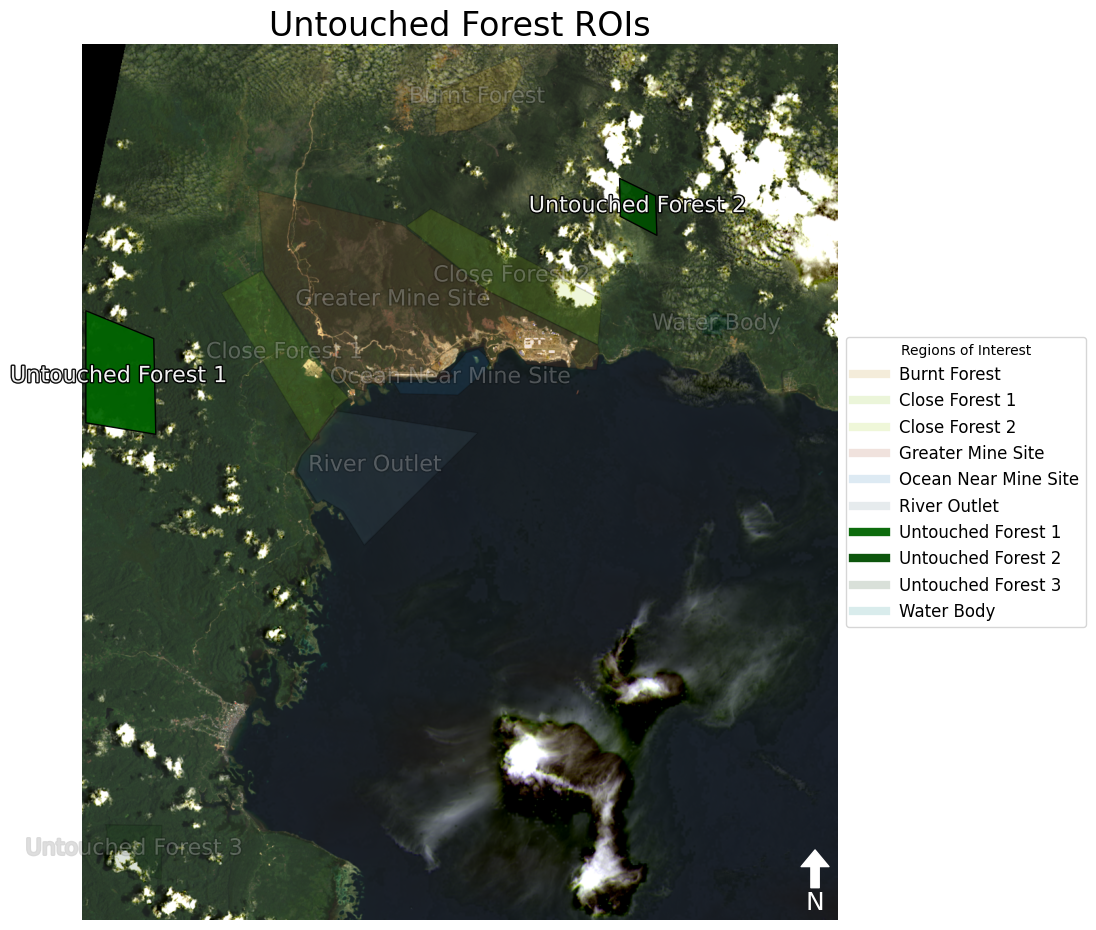

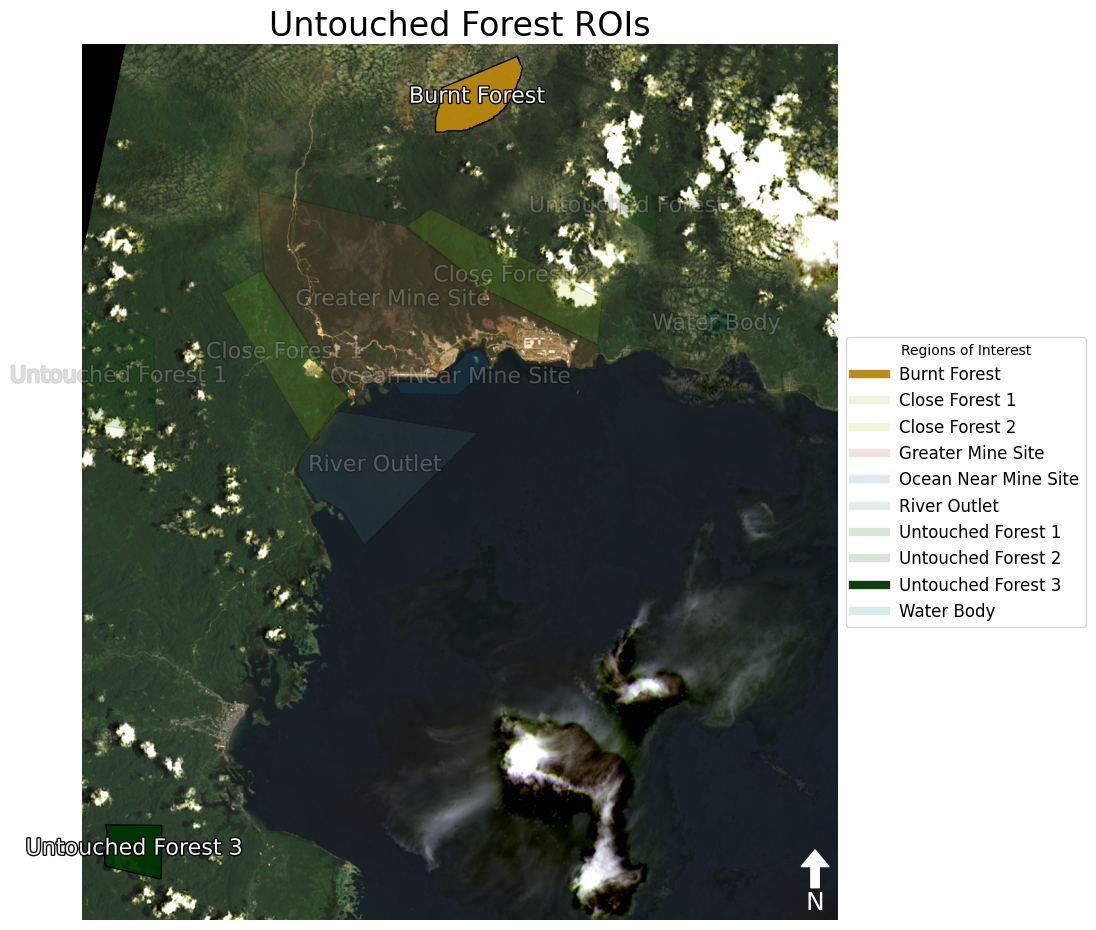

In [ ]:
reload(composite_analysis)
composite_analysis.plot_rois_on_basemap(rois_initial_analysis_dir, derived_folder + '/LC08_L2SP_109060_20200310_20200822_02_T1/RGB', roi_colours, highlight_rois=close_forest_rois, title='Close Forest ROIs')
composite_analysis.plot_rois_on_basemap(rois_initial_analysis_dir, derived_folder + '/LC08_L2SP_109060_20200310_20200822_02_T1/RGB', roi_colours, highlight_rois=['untouched_forest_1', 'untouched_forest_2'], title='Untouched Forest ROIs')
composite_analysis.plot_rois_on_basemap(rois_initial_analysis_dir, derived_folder + '/LC08_L2SP_109060_20200310_20200822_02_T1/RGB', roi_colours, highlight_rois=['untouched_forest_3', 'burnt_forest'], title='Untouched Forest ROIs')

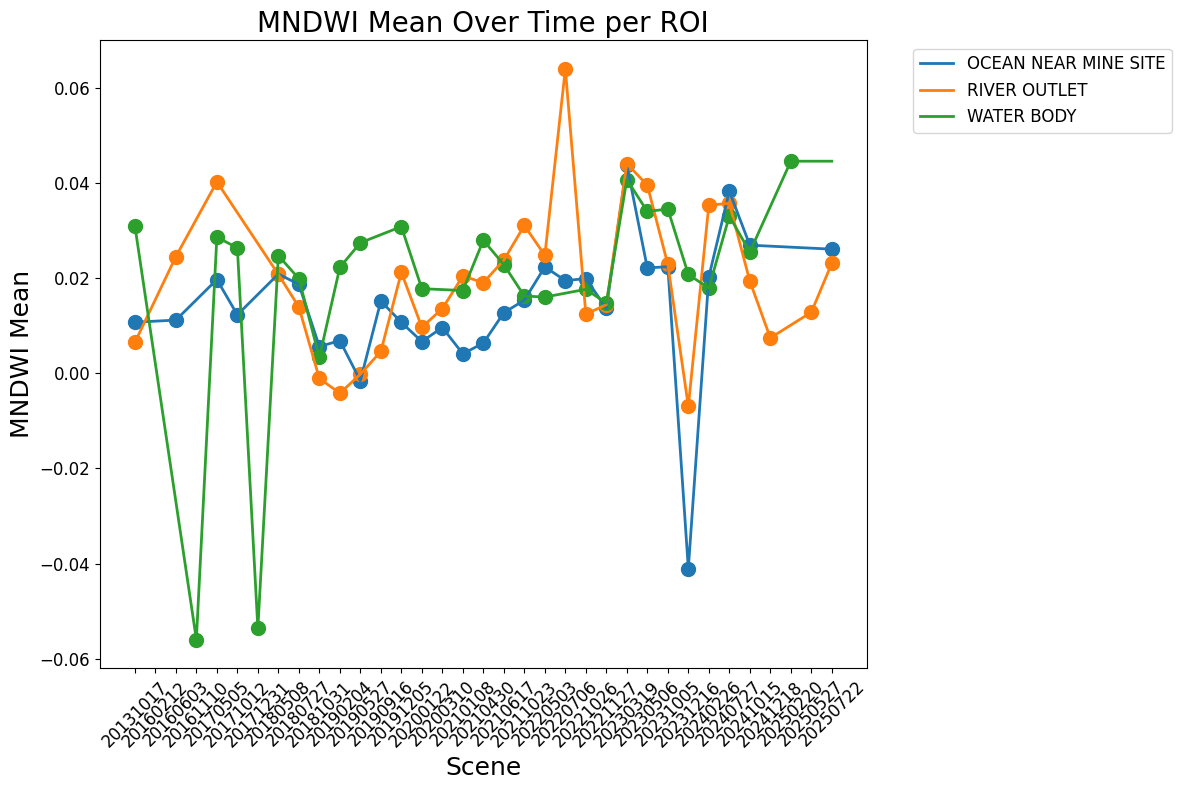

In [60]:
reload(composite_analysis)

temp_plot = composite_analysis.plot_composite_over_time(all_stats_filtered_on_cloud, composite='MNDWI', stat='mean', rois=water_rois)

- RGB – A true-colour composite useful for visual interpretation and validating spectral indices by resembling what the human eye sees. It helps distinguish broad land-cover features like vegetation, soil, and water bodies.

- NDVI (Normalized Difference Vegetation Index) – Quantifies vegetation greenness and health based on red and NIR reflectance; higher values indicate denser, healthier vegetation. Ideal for tracking vegetation cover and growth dynamics.

- MNDWI (Modified Normalized Difference Water Index) – Enhances open water detection by suppressing built-up and vegetation noise; effective for delineating water bodies and monitoring surface water changes.

- NDBI (Normalized Difference Built-up Index) – Highlights built-up or bare soil areas using SWIR and NIR bands; useful for separating impervious surfaces from vegetated and water areas.

- EVI (Enhanced Vegetation Index) – Similar to NDVI but minimizes atmospheric and soil background effects, making it better for dense canopies.

- SAVI (Soil-Adjusted Vegetation Index) – Adjusts NDVI to reduce soil brightness influence; valuable in sparsely vegetated regions or where bare soil is prominent.

- FERRIC_IRON – Emphasizes ferric iron oxide presence, indicating oxidized or weathered soils and potential mineralization; useful for understanding soil composition and geology.

- NDMI (Normalized Difference Moisture Index) – Sensitive to vegetation and soil moisture by comparing NIR and SWIR reflectance; helps identify drought stress or wet soil conditions.

- BAI (Bare Soil Index) – Enhances detection of bare soil and dry areas using visible and NIR bands; useful for distinguishing exposed earth from vegetation.

- SI (Salinity Index) – Detects soil salinity using combinations of visible and NIR reflectance; important for assessing soil degradation in arid or irrigated landscapes.

- NDSI (Normalized Difference Snow/Soil Index) – Useful for differentiating bright soil from other reflective surfaces like sand or salt crusts, improving land-surface classification.

- NDGI (Normalized Difference Greenness Index) – Complements NDVI by emphasizing green vegetation intensity; useful for subtle changes in vegetation density or crop health.

- Ferric Iron Index (already using) – sensitive to Fe³⁺ oxides, useful for detecting iron-rich laterites or exposed soil after clearing.

- Ferrous Iron Index (e.g., Ferrous Mineral Index, FFI) – targets Fe²⁺ minerals, often associated with mafic/ultramafic rocks that can host nickel deposits.

- Iron Oxide Ratio (IOR) – uses reflectance differences in the red-edge and visible bands to highlight iron oxide abundance in soils.

- Clay Mineral Index (CMI) – can highlight clay alteration associated with nickel laterites, particularly when mining exposes regolith layers.

- Nickel-specific proxies via spectral bands – while there isn’t a direct “nickel index,” Ni-rich laterites often co-occur with Fe²⁺/Fe³⁺ minerals and Mg-rich ultramafics, so combining ferrous/ferric indices with Mg-OH bands (SWIR) can highlight potential nickel-bearing soils.

# TESTING

In [ ]:
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import rasterio
import rasterio.features
import numpy as np
import matplotlib.pyplot as plt

reload(composite_analysis)

# Paths to your test raster and QA_PIXEL raster
rgb_2022_path = derived_folder + '/20220503_LC08_B1-B2-B3-B4-B5-B6-B7-B10-QA_PIXEL/RGB'
qa_2022_path = clipped_folder + '/LC08_L2SP_109060_20220503_20220511_02_T1/QA_PIXEL'
ndvi_2022_path = derived_folder + '/20220503_LC08_B1-B2-B3-B4-B5-B6-B7-B10-QA_PIXEL/NDVI'


# the ROI mask will stay the same across all scenes (multiple dates)
roi_masks = composite_analysis.compute_roi_masks(rois_initial_analysis_dir, qa_2022_path)

# for all scenes in the input folder...
# the cloud mask, combined mask and cloud fractions will stay the same across one scene (multiples indices and composites)
cloud_mask = composite_analysis.get_cloud_mask(qa_2022_path)

combined_masks = {roi: roi_mask & (~cloud_mask) for roi, roi_mask in roi_masks.items()}
cloud_fractions = composite_analysis.compute_cloud_fraction_per_roi(roi_masks, cloud_mask) 

# for each composite/index, compute the stats
stats = composite_analysis.compute_index_stats_for_roi_cloud_masked(ndvi_2022_path, combined_masks)


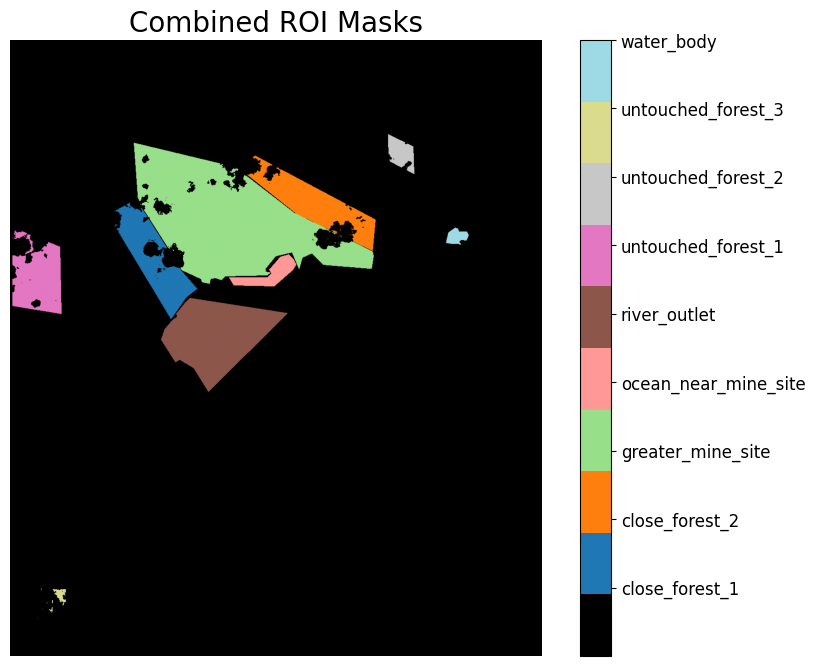

In [ ]:
from matplotlib.colors import ListedColormap
def plot_combined_roi_masks(combined_masks):
    shape = next(iter(combined_masks.values())).shape
    canvas = np.zeros(shape, dtype=int)

    for i, (_, mask) in enumerate(combined_masks.items(), start=1):
        canvas[mask] = i

    # build colormap: black for background + tab20 for ROIs
    base_cmap = plt.get_cmap('tab20', len(combined_masks))
    colors = np.vstack(([0, 0, 0, 1], base_cmap(np.arange(len(combined_masks)))))  # prepend black
    cmap = ListedColormap(colors)

    plt.figure()
    im = plt.imshow(canvas, cmap=cmap)
    plt.axis('off')
    plt.title('Combined ROI Masks')

    cbar = plt.colorbar(im, ticks=np.arange(1, len(combined_masks)+1))
    cbar.ax.set_yticklabels(list(combined_masks.keys()))
    plt.show()

# Usage
plot_combined_roi_masks(combined_masks)

In [ ]:
raw_ex_dir = raw_folder + '/L8_20220503'
envi_folder = data_folder + '/envi'

raw_b2 = raw_ex_dir + '/LC08_L2SP_109060_20220503_20220511_02_T1_SR_B2.TIF'
raw_b3 = raw_ex_dir + '/LC08_L2SP_109060_20220503_20220511_02_T1_SR_B3.TIF'
raw_b4 = raw_ex_dir + '/LC08_L2SP_109060_20220503_20220511_02_T1_SR_B4.TIF'
raw_b5 = raw_ex_dir + '/LC08_L2SP_109060_20220503_20220511_02_T1_SR_B5.TIF'

envi_clipped_b2 = envi_folder + '/b2_clipped'
envi_clipped_b3 = envi_folder + '/b3_clipped'
envi_clipped_b4 = envi_folder + '/b4_clipped'
envi_clipped_b5 = envi_folder + '/b5_clipped'

## Cloud Masking

Masked pixels: 250859
Total pixels: 1435770
Percentage masked: 17.47%


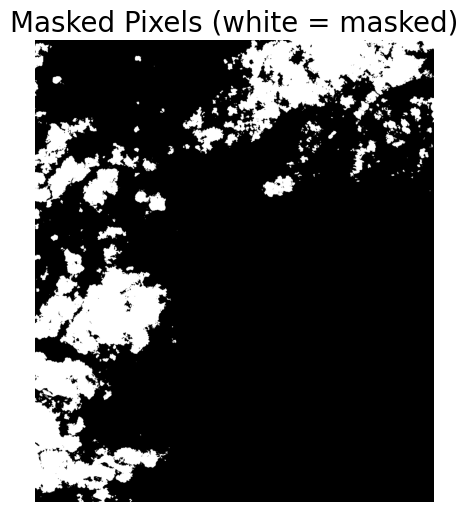

In [ ]:
import numpy as np

reload(composite_analysis)

# Mask the scene raster
masked_arr = composite_analysis.mask_clouds_in_scene_raster(rgb_2022_path, qa_2022_path)

# Count masked pixels
num_masked = np.isnan(masked_arr).sum()
total_pixels = masked_arr.size
percent_masked = (num_masked / total_pixels) * 100

print(f'Masked pixels: {num_masked}')
print(f'Total pixels: {total_pixels}')
print(f'Percentage masked: {percent_masked:.2f}%')

# Quick visualization: masked vs unmasked
plt.figure(figsize=(6, 6))
plt.imshow(np.isnan(masked_arr), cmap='gray')
plt.title('Masked Pixels (white = masked)')
plt.axis('off')
plt.show()

## Compare rasters - metadata and band values pixel by pixel

In [ ]:
import numpy as np

def compare_rasters(path1, path2):
    with rasterio.open(path1) as r1, rasterio.open(path2) as r2:
        meta_keys = ['crs', 'transform', 'width', 'height', 'dtype', 'nodata']
        diffs = {}
        for k in meta_keys:
            if r1.profile[k] != r2.profile[k]:
                diffs[k] = (r1.profile[k], r2.profile[k])

        bounds_diff = [abs(a - b) for a, b in zip(r1.bounds, r2.bounds)]
        if any(d > 1e-6 for d in bounds_diff):
            diffs['bounds'] = bounds_diff

        arr1 = r1.read(1)
        arr2 = r2.read(1)
        if arr1.shape != arr2.shape:
            diffs['shape'] = (arr1.shape, arr2.shape)

    if diffs:
        print("Differences found:")
        for k, v in diffs.items():
            print(f"  {k}: {v}")
        return False
    else:
        print("No metadata differences found.")
        return True

def compare_band_values(path1, path2):
    with rasterio.open(path1) as r1, rasterio.open(path2) as r2:
        arr1 = r1.read(1).astype(float)
        arr2 = r2.read(1).astype(float)
        if arr1.shape != arr2.shape:
            print(f"Shape mismatch: {arr1.shape} vs {arr2.shape}")
            return False

        diff = arr1 - arr2
        mean_diff = np.nanmean(diff)
        std_diff = np.nanstd(diff)
        max_abs_diff = np.nanmax(np.abs(diff))

        if any(abs(x) > 1e-6 for x in [mean_diff, std_diff, max_abs_diff]):
            print(f"Value differences detected:\n"
                  f"  mean_diff={mean_diff}, std_diff={std_diff}, max_abs_diff={max_abs_diff}")
            return False

    print("No pixel value differences found.")
    return True

test2 = clipped_folder + '/LC08_L2SP_109060_20220503_20220511_02_T1/B3.dat'
compared_meta=compare_rasters(test2, envi_clipped_b3)
display(compared_meta)
compared = compare_band_values(test2, envi_clipped_b3)
compared

No metadata differences found.


True

No pixel value differences found.


True

## Test Stacked

In [72]:

def compare_multiband_rasters(path1, path2, tol=1e-6):
    """
    Compare two multiband rasters.
    Prints differences only if they exist.
    Returns True if identical, False otherwise.
    """
    with rasterio.open(path1) as r1, rasterio.open(path2) as r2:
        # Check basic metadata
        meta_keys = ['crs', 'transform', 'width', 'height', 'dtype', 'count', 'nodata']
        diffs = {}
        for k in meta_keys:
            if r1.profile[k] != r2.profile[k]:
                diffs[k] = (r1.profile[k], r2.profile[k])

        if diffs:
            print("Metadata differences found:")
            print('  ENVI  |  Computed')
            for k, v in diffs.items():
                print(f"  {k}: {v}")

        # Compare each band
        value_diffs = False
        for b in range(1, r1.count + 1):
            arr1 = r1.read(b).astype(float)
            arr2 = r2.read(b).astype(float)
            if arr1.shape != arr2.shape:
                print(f"Band {b} shape mismatch: {arr1.shape} vs {arr2.shape}")
                value_diffs = True
                continue
            diff = arr1 - arr2
            max_abs_diff = np.nanmax(np.abs(diff))
            if max_abs_diff > tol:
                print(f"Band {b} max absolute difference: {max_abs_diff}")
                value_diffs = True

    if not diffs and not value_diffs:
        print("No differences found: metadata and pixel values match.")
        return True
    else:
        return False


In [74]:
scene_name_2022 = 'LC08_L2SP_109060_20220503_20220511_02_T1'

envi_stacked_all_bands = envi_folder + '/envi_stacked_all_bands'
stacked_test_2022 = '/'.join([stacked_folder, scene_name_2022, scene_name_2022])

compare_multiband_rasters(envi_stacked_all_bands, stacked_test_2022)

Metadata differences found:
  ENVI  |  Computed
  nodata: (None, 0.0)


False

## Test non-automated

In [80]:
def compare_floating_rasters(input1, input2, tol=1e-6):
    import rasterio
    import numpy as np

    def load_raster(x):
        if isinstance(x, str):  # path
            with rasterio.open(x) as src:
                return src.read(1).astype(float), src.profile
        else:  # assume it's already a NumPy array
            return x.astype(float), None

    arr1, _ = load_raster(input1)
    arr2, _ = load_raster(input2)

    if arr1.shape != arr2.shape:
        print(f"Shape mismatch: {arr1.shape} vs {arr2.shape}")
        return False
    
    mask = np.isfinite(arr1) & np.isfinite(arr2)
    diff = arr1[mask] - arr2[mask]
    
    max_abs_diff = np.max(np.abs(diff))
    mean_diff = np.mean(diff)
    num_diff_pixels = np.sum(np.abs(diff) > tol)
    print("arr1:", np.concatenate([arr1.ravel()[:5], arr1.ravel()[-5:]]))
    print("arr2:", np.concatenate([arr2.ravel()[:5], arr2.ravel()[-5:]]))

    if num_diff_pixels > 0:
        print(f"Floating-point differences detected:")
        print(f"  Max absolute difference: {max_abs_diff}")
        print(f"  Mean difference: {mean_diff}")
        print(f"  Number of differing pixels: {num_diff_pixels}")
        print(f'  Number of total pixels {arr1.size}')
        return False

    print("Rasters match within tolerance.")
    return True

In [81]:
ndvi_test_2022 = '/'.join([derived_folder, scene_name_2022, 'ndvi'])
envi_ndvi_path = envi_folder + '/envi_ndvi'

compare_floating_rasters(ndvi_test_2022, envi_ndvi_path, tol=1e-7)

arr1: [ 0.45704144  0.46795988  0.44856927  0.43087697  0.44401652 -0.00138007
 -0.0015164  -0.00110421 -0.00110284 -0.00055157]
arr2: [ 0.45704144  0.46795988  0.44856927  0.43087697  0.44401652 -0.00138007
 -0.0015164  -0.00110421 -0.00110284 -0.00055157]
Rasters match within tolerance.


True

In [ ]:
ndvi_test_2022 = '/'.join([derived_folder, scene_name_2022, 'ndvi'])
envi_ndvi_path = envi_folder + '/envi_ndvi'

compare_floating_rasters(ndvi_test_2022, envi_ndvi_path, tol=1e-7)

[[ 10.   0.  14. ...  27.  34.  27.]
 [  0.   0.   7. ...  31.  58.  67.]
 [  0.   0.   8. ...  47.  67.  97.]
 ...
 [ 39.  22.  22. ... 252. 251. 251.]
 [ 42.  30.  24. ... 252. 251. 252.]
 [ 39.  43.  32. ... 252. 251. 251.]]
[[-0.27016929 -0.28679714 -0.26547372 ... -0.2515313  -0.24333334
  -0.25141656]
 [-0.29277962 -0.28953955 -0.27353132 ... -0.24658193 -0.2160355
  -0.20587058]
 [-0.29617646 -0.28755659 -0.27289551 ... -0.22818711 -0.20625551
  -0.17183831]
 ...
 [-0.23754904 -0.25738344 -0.25686845 ...  0.00454045  0.00350877
   0.00295594]
 [-0.23420994 -0.24727149 -0.25496322 ...  0.00447381  0.00378241
   0.00413052]
 [-0.23723798 -0.23281011 -0.2455097  ...  0.00440226  0.00350684
   0.00316325]]
Floating-point differences detected:
  Max absolute difference: 254.99258070997894
  Mean difference: 168.17207157398568
  Number of differing pixels: 1435770
  Number of total pixels 1435770


False